In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Suponiendo que el archivo CSV se llama 'base_de_datos_1.csv'
df = pd.read_csv('/content/datos.csv', delimiter=';')

# Mostras base de datos
print(df.head())

   Unnamed: 0 Descripcion_Area_Rural   Furips_Descripcion        Ciudad  \
0           0                  RURAL  se estrelló de novi  BARRANQUILLA   
1           1                  RURAL  se estrelló de novi  BARRANQUILLA   
2           2                  RURAL  se estrelló de novi  BARRANQUILLA   
3           3                  RURAL  se estrelló de novi  BARRANQUILLA   
4           4                  RURAL  se estrelló de novi  BARRANQUILLA   

  Marca_Vehiculo Estado_Vehiculo_Descripcion Tipo_Vehiculo_Descripcion  \
0        reanaul                   Asegurado                Particular   
1        reanaul                   Asegurado                Particular   
2        reanaul                   Asegurado                Particular   
3        reanaul                   Asegurado                Particular   
4        reanaul                   Asegurado                Particular   

  Tipo_Vehiculo Condicion_Accidentado_Descripcion  \
0     Automovil                          Ocupante  

In [ ]:

!pip install keras-tuner

import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from keras_tuner import RandomSearch, HyperModel
from tensorflow.keras.regularizers import l1_l2


df['text_for_lda'] = df['Furips_Descripcion'].astype(str) + ' ' + df['Categoria_Descripcion_Eje10'].astype(str)

# Preprocesamiento de texto para LDA
def preprocess_text(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(token)
    return result

# Preprocesa texto, construcción de diccionario, crea modelo LDA con 44 temas
documents = df['text_for_lda'].map(preprocess_text)

dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]

num_topics = 44
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=20, workers=2)

# Convertir los documentos a vectores de temas
ldafeatures = [lda_model[doc] for doc in corpus]
lda_features_matrix = np.array([[dict(doc).get(i, 0) for i in range(num_topics)] for doc in ldafeatures])

# One-hot encoding para variables categóricas
categorical_vars = ['Descripcion_Area_Rural', 'Ciudad', 'Marca_Vehiculo', 'Estado_Vehiculo_Descripcion', 'Tipo_Vehiculo_Descripcion', 'Tipo_Vehiculo', 'Condicion_Accidentado_Descripcion']
df_cat = pd.get_dummies(df[categorical_vars])

# Concatenar las características categóricas con las características LDA
X = np.hstack((df_cat.values, lda_features_matrix))

# Codificación de la variable objetivo
le = LabelEncoder()
y = le.fit_transform(df['Fraude'].values)

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicación de SMOTE con parámetros modificados
smote = SMOTE(
    sampling_strategy= 0.7,  # Proporción de la cantidad de instancias de la clase minoritaria respecto a la clase mayoritaria después del re-muestreo. 0.5 significa que la clase minoritaria tendrá la mitad de los ejemplos de la clase mayoritaria.
    random_state=42,
    k_neighbors=5 ,  # Número de vecinos más cercanos para construir ejemplos sintéticos. Aumentar para suavizar la frontera de decisión.
    n_jobs=-1  # Número de núcleos de CPU a utilizar. -1 significa usar todos disponibles.
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Calculando pesos de clase para manejar desequilibrios
weights = compute_class_weight('balanced', classes=np.unique(y_train_smote), y=y_train_smote)
class_weights = dict(enumerate(weights))

# Definición de la clase HyperModel para la red neuronal
class NeuralNetworkHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=512, step=64),
                        activation='relu',
                        kernel_regularizer=l1_l2(l1=hp.Float('l1_1', min_value=1e-5, max_value=1e-2, sampling='LOG'),
                                                 l2=hp.Float('l2_1', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                        input_shape=(self.input_shape,)))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0, max_value=0.5, step=0.1)))

        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(Dense(units=hp.Int(f'units_{i+2}', min_value=64, max_value=512, step=64),
                            activation='relu',
                            kernel_regularizer=l1_l2(l1=hp.Float(f'l1_{i+2}', min_value=1e-5, max_value=1e-2, sampling='LOG'),
                                                     l2=hp.Float(f'l2_{i+2}', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
            model.add(BatchNormalization())
            model.add(Dropout(rate=hp.Float(f'dropout_{i+2}', min_value=0, max_value=0.5, step=0.1)))

        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

input_shape = X_train_smote.shape[1]
hypermodel = NeuralNetworkHyperModel(input_shape)

# Inicialización de RandomSearch
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='random_search',
    project_name='FraudeDetection',
    overwrite=True
)

# Callbacks para EarlyStopping y ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Búsqueda de hiperparámetros
tuner.search(X_train_smote, y_train_smote, epochs=100, batch_size=32, class_weight=class_weights, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# Obtener el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]

# Búsqueda de hiperparámetros
tuner.search(X_train_smote, y_train_smote, epochs=100, batch_size=32, class_weight=class_weights, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# Obtener el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluación de la red neuronal con el mejor modelo
nn_predictions_prob = best_model.predict(X_test)
nn_predictions = (nn_predictions_prob > 0.5).astype(int)

# Calcular la precisión final
final_accuracy = accuracy_score(y_test, nn_predictions)
print(f'Final Accuracy: {final_accuracy}')




Trial 5 Complete [00h 04m 21s]
val_accuracy: 0.5219617411494255

Best val_accuracy So Far: 0.9140393435955048
Total elapsed time: 00h 30m 31s


99/99 [==============================] - 0s 2ms/step
Final Accuracy: 0.7213946117274168


99/99 [==============================] - 1s 3ms/step
Precisión de la Red Neuronal: 43.45%
Reporte de clasificación de la Red Neuronal:
              precision    recall  f1-score   support

           0       0.96      0.37      0.53      2758
           1       0.17      0.89      0.28       397

    accuracy                           0.43      3155
   macro avg       0.56      0.63      0.41      3155
weighted avg       0.86      0.43      0.50      3155



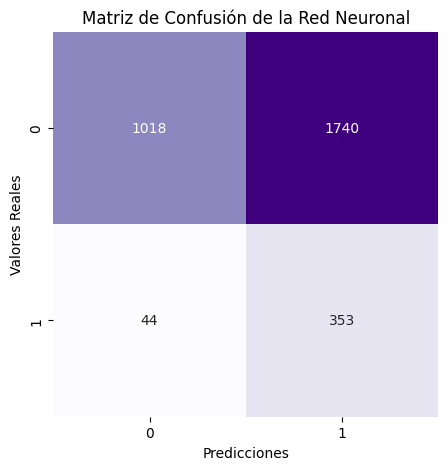

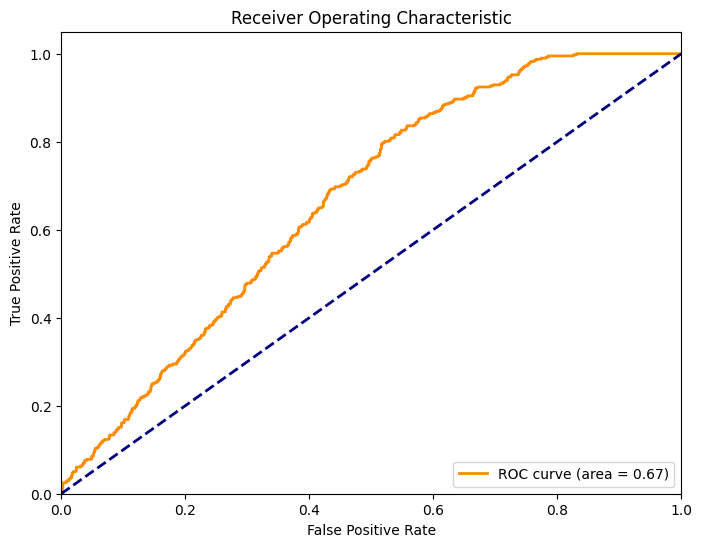

AUC: 0.67


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Cargar el mejor modelo guardado
model = load_model('best_model.h5')

# Hacer predicciones con el conjunto de prueba
nn_predictions_prob = model.predict(X_test)
nn_predictions = (nn_predictions_prob > 0.5).astype(int)

# Calcular la precisión
nn_accuracy = accuracy_score(y_test, nn_predictions)
print(f'Precisión de la Red Neuronal: {nn_accuracy * 100:.2f}%')

# Reporte de clasificación
print("Reporte de clasificación de la Red Neuronal:")
print(classification_report(y_test, nn_predictions))

# Matriz de confusión
cm_nn = confusion_matrix(y_test, nn_predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Purples", square=True, cbar=False)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión de la Red Neuronal')
plt.show()

# Cálculo de las tasas de verdaderos positivos (TPR), falsos positivos (FPR), y el área bajo la curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, nn_predictions_prob[:, 0])
roc_auc = auc(fpr, tpr)

# Dibujar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Imprimir el AUC
print(f'AUC: {roc_auc:.2f}')

In [ ]:
# Obtener el valor de val_accuracy del mejor modelo con los datos de entrenamiento
best_model_val_accuracy = best_model.evaluate(X_train_smote, y_train_smote)[1]

print(f'Val Accuracy del mejor modelo con los datos de entrenamiento: {best_model_val_accuracy}')


580/580 [==============================] - 2s 2ms/step - loss: 0.4739 - accuracy: 0.8247
Val Accuracy del mejor modelo con los datos de entrenamiento: 0.8247372508049011
